# Exploring the Distribution of Mass in Galaxies

This notebook uses results from decomposing galaxies into separate mass components (i.e. stellar bulge, stellar disk, gas disk, and dark matter halo) to explore whether the distribution of mass is correlated with integrated and radial properties of the gas and stars. I aim to do the following:

1. Compute fundamental characteristics of the gas and stars in galaxies (i.e., sizes, masses, colors, star formation rates, etc.).
2. Compute distributions of baryon to total mass fractions and define metrics for describing them.
3. Explore whether galaxies with similar mass distribution metrics have similar baryon properties.
4. Explore the possibility of using one or some combination of observed properties to predict the distribution of mass in galaxies.

Keep in mind this is an active, incomplete work environment.

Last update: 8/2/16

## Forming the data frame
Many of the directly measured properties from the observational data are stored in a csv file.

In [1]:
import pandas as pd
import numpy as np
from uncertainties import unumpy
# Homemade functions
from calculateParams import *
from rcd_results import *

# Set some Pandas options
#pd.set_option('html', False)
pd.set_option('max_columns', 10)
pd.set_option('max_rows', 20)

In [2]:
df = pd.read_csv("for_pandas.csv", index_col=0)

In [3]:
df.head()

,Done?,DMpc,D_ID,T-type,A_B,...,log(EW)_grad,(B-R)_grad,incl,Vflat,Vflaterr
Galaxy,,,,,,,,,,,
NGC 3486,Y,8.47,H,5,0.078,...,-0.153,-0.191,44.2,139.94,9.65
NGC 3507,Y,11.80,H,3,0.089,...,-0.302,-0.008,17.0,225.87,47.31
UGC 06161,Y,10.60,H,8,0.044,...,-0.920,0.040,53.0,74.53,6.31
NGC 3675,Y,10.80,H,3,0.071,...,-0.373,-0.006,67.8,204.50,9.44
NGC 3718,Y,14.60,H,1,0.051,...,0.047,-0.115,81.1,250.11,7.59


## Calculate properties of gas and stars
Most of the properties that will be used in the analysis are derived from these raw observations and need to be added to the data frame.

In [4]:
# Start with calculating the LTF distance:
logLNIR_LTF = -0.28 + 4.93*(np.log10(df.Vflat))
MNIR_LTF = 3.24 - 2.5*(logLNIR_LTF)
df['DLTF'] = (10**(((df['m_3.6,tot'] - MNIR_LTF)/5.) + 1.))/(1E6)

In [5]:
# Create new column with the correct distance to be used going forwards:
# Use DMpc if the distance method is something other than Hubble flow ('H'), and DLTF otherwise
df['Duse'] = df.DLTF
df.loc[df.D_ID != 'H', 'Duse'] = df.DMpc
#df[['DMpc','DLTF','D_ID','Duse']]

## Stellar population properties
#### Absolute B-band magnitude & B-R color

In [6]:
# Calculate absolute B-band magnitude, extinction corrected colors at R25
# Call functions extinctMag and absMag from calculateParams.py

df['mB0'] = extinctMag(df['m_B,tot'], df.m_B_err, df.A_B)
df['M_B'] = absMag(df.Duse, df.mB0)
mB025 = extinctMag(df.m_B, df.m_B_err, df.A_B)
mR025 = extinctMag(df.m_R, df.m_R_err, df.A_R)
#mNIR025 = extinctMag(df['m_3.6'], df['m_3.6_err'],0)
df['BR025'] = mB025 - mR025
#df['BNIR025'] = mB025 - mNIR025
#df['RNIR025'] = mR025 - mNIR025

#### Star formation rate

In [7]:
# Calculate SFR
# Call function calcSFR
df['SFR'] = calcSFR(df.Duse, df['log(F_Ha)'], df['log(F_Ha)_err'])

## Stellar, gas & total baryon masses

In [8]:
# Calculate HI, H2 & total gas masses
# Call function calcGasMass
df['MHI'], df['MH2'], df['Mgas'] = calcGasMass(df.Duse, df.F_HI, df.F_CO, df.F_CO_err)

In [9]:
# Calculate stellar mass, asuming M/L = 0.5
# Call function calcStellarMass
df['Mstar'] = calcStellarMass(df.Duse, df['m_3.6,tot'], 0.5)[1]

In [10]:
# Calculate stellar mass-normalized SFR (specific SFR)
df['SSFR'] = (df['SFR'] / df['Mstar']) * (1E9)

In [11]:
# Calculate total baryon mass
df['Mbary'] = df['Mgas'] + df['Mstar']

## Linearize size measures

In [12]:
# Calculate linear (kpc) quantities
# Call function linearize from claculateParams.py
df['hkpc'] = linearize(df.Duse, df.h_R)
df['d25kpc'] = linearize(df.Duse, df.D_25)
df['dhikpc'] = linearize(df.Duse, df.D_HI)

#### Linearize B-R color and EW gradients

In [13]:
df['BRgradkpc'] = ((df['(B-R)_grad']/60.)*206.265)/df.Duse
df['logEWgradkpc'] = ((df['log(EW)_grad']/60.)*206.265)/df.Duse

## Exploring properties of the gas and stars

Before moving on to the mass distribution metrics, I can get a sense of the relationships that exist among the gas and stars. For now, I'll just focus on how properties of the stellar populations depend on the total baryon mass of the galaxy. 

In all plots the color of the points represents the B-R color and the size is scaled by the morphological T-type, where bigger points represent less massize dwarf galaxies, intermediate sizes represent spiral galaxies, and smaller points represent more massive spheroidal type galaxies.

In [14]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rc('font', family='serif')
plt.rc('font', serif='Computer Modern Roman')
plt.rc('text',usetex='true')
rcParams['axes.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
rcParams['legend.fontsize'] = 15
rcParams['axes.titlesize'] = 15

In [15]:
galColor = plt.cm.get_cmap('seismic')

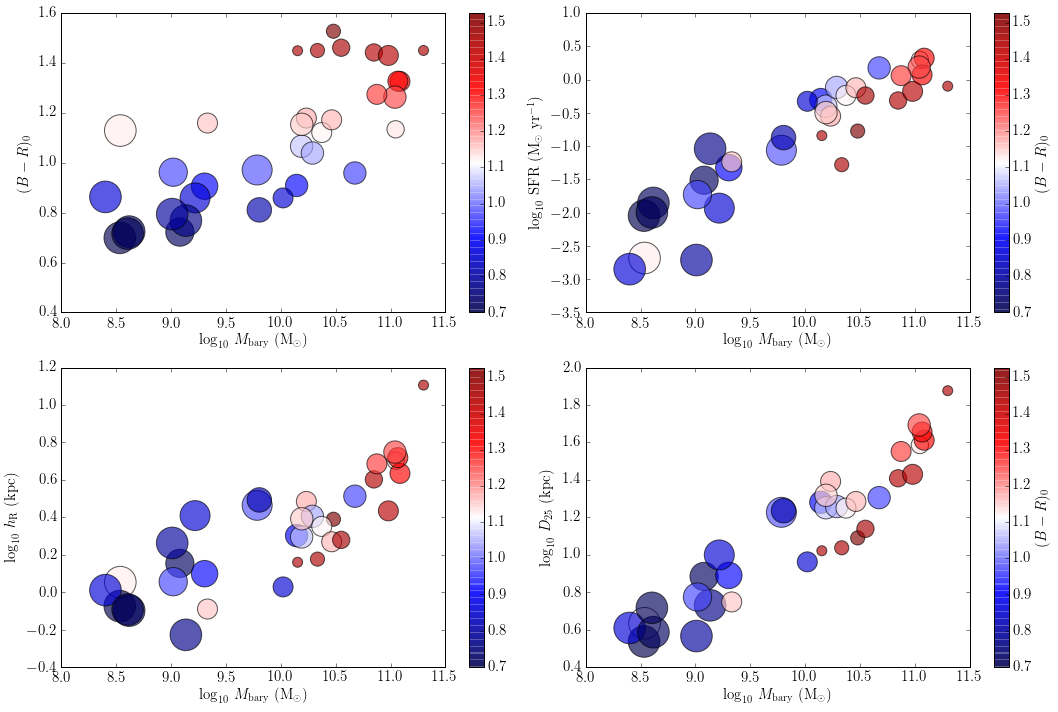

In [16]:
plt.figure(figsize=(15,10))

plt.subplot(221)
BRvsMbary = plt.scatter(unumpy.nominal_values(unumpy.log10(df['Mbary'])),unumpy.nominal_values(df['BR025']),
                        c=unumpy.nominal_values(df['BR025']),s=np.absolute(df['T-type'])*100,cmap=galColor,alpha=0.65)
plt.xlabel('$\log_{10}$ $M_\mathrm{bary}$ (M$_{\odot}$)')
plt.ylabel('($B-R$)$_0$')
plt.colorbar()

plt.subplot(222)
SFRvsMbary = plt.scatter(unumpy.nominal_values(unumpy.log10(df['Mbary'])),unumpy.nominal_values(unumpy.log10(df['SFR'])),
                         c=unumpy.nominal_values(df['BR025']),s=np.absolute(df['T-type'])*100,cmap=galColor,alpha=0.65)
plt.xlabel('$\log_{10}$ $M_\mathrm{bary}$ (M$_{\odot}$)')
plt.ylabel('$\log_{10}$ SFR (M$_{\odot}$ yr$^{-1}$)')
cbar = plt.colorbar()
cbar.set_label('($B-R$)$_0$')

plt.subplot(223)
hvsMbary = plt.scatter(unumpy.nominal_values(unumpy.log10(df['Mbary'])),unumpy.nominal_values(unumpy.log10(df['hkpc'])),
                         c=unumpy.nominal_values(df['BR025']),s=np.absolute(df['T-type'])*100,cmap=galColor,alpha=0.65)
plt.xlabel('$\log_{10}$ $M_\mathrm{bary}$ (M$_{\odot}$)')
plt.ylabel('$\log_{10}$ $h_\mathrm{R}$ (kpc)')
plt.colorbar()

plt.subplot(224)
hvsMbary = plt.scatter(unumpy.nominal_values(unumpy.log10(df['Mbary'])),unumpy.nominal_values(unumpy.log10(df['d25kpc'])),
                         c=unumpy.nominal_values(df['BR025']),s=np.absolute(df['T-type'])*100,cmap=galColor,alpha=0.65)
plt.xlabel('$\log_{10}$ $M_\mathrm{bary}$ (M$_{\odot}$)')
plt.ylabel('$\log_{10}$ $D_{25}$ (kpc)')
cbar = plt.colorbar()
cbar.set_label('($B-R$)$_0$')

plt.tight_layout()
#plt.savefig("StellarPropsvsMbary.pdf")

Correlations are evident between the total baryonic mass, size, B-R color, SFR, disk scale length, and even morphological type:

1. Blue galaxies tend to be less massive than red galaxies.
2. Dwarf galaxies tend to be the bluest and least massive galaxies.
3. Blue, less massive galaxies tend to have lower overall SFRs.
4. Blue, less massive galaxies tend to have short disk scale lengths.
5. Blue, less massive galaxies tend to have smaller optical sizes.

There is a lot of redundancy here in terms of how a galaxy can be described. It is likely possible to decrease the number of attributes, or dimensions, we have to think about. We'll come back to this later.

## Creating metrics for the distribution of mass

The metrics are computed from text files containing information about the distribution of mass in separate components, including the dark matter halo, gas disk, stellar disk and, in some cases, stellar bulge. A suite of functions was created in rcd_results.py for extracting and calculating all the necessary parameters.

In [17]:
## Start by reading all the files into a list ##

with open("bestRotfitFiles.txt", 'r') as f:
    bestMLFiles = f.read().splitlines()

### Radial distribution of baryon mass fraction...
...or distribution of mass in gas & stars relative to the total mass of the galaxy, as determined by the strength of the graviational potential.

In [18]:
## Define plotting functions to separate galaxies by maximum rotational velocity

def plot_biggest(x, y):
    Vf200, = plt.plot(x, y, 'k', lw=3)
    return Vf200

def plot_big(x, y):
    Vf100, = plt.plot(x, y, 'k', lw=1)
    return Vf100

def plot_small(x, y):
    Vf0, = plt.plot(x, y, 'k', lw=2, ls='dotted')
    return Vf0

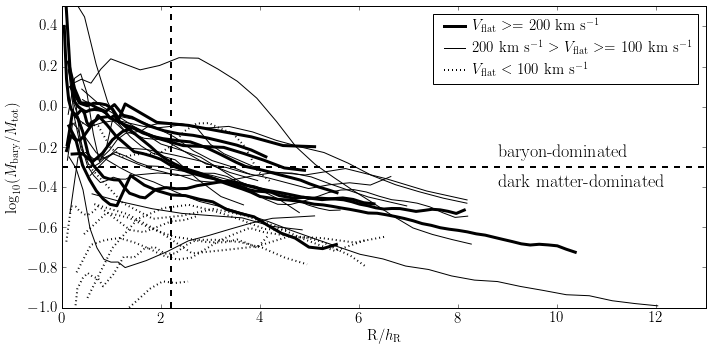

In [19]:
plt.figure(figsize=(10,5))

#plt.title('Fixed M/L')
plt.xlabel('R/$h_\mathrm{R}$')
plt.ylabel('$\log_{10}$($M_\mathrm{bary}$/$M_\mathrm{tot}$)')
plt.axhline(y=np.log10(0.5), color='black', linewidth=2, linestyle='dashed')
plt.axvline(x=2.2, color='black', linewidth=2, linestyle='dashed')
plt.text(8.8, (np.log10(0.5)+0.05), 'baryon-dominated', fontsize=18)
plt.text(8.8, (np.log10(0.5)-0.1), 'dark matter-dominated', fontsize=18)
for file in bestMLFiles:
    gal, r, Mrat = massFracDist(file)
    logMrat = np.log10(Mrat)
    hkpcGal = df['hkpc'][gal]
    VfGal = df['Vflat'][gal]
    rh = r/hkpcGal
    if VfGal >= 200:
        Vf200 = plot_biggest(rh, logMrat)
    elif VfGal < 200 and VfGal >= 100:
        Vf100 = plot_big(rh, logMrat)
    else:
        Vf0 = plot_small(rh, logMrat)
plt.xlim(0,13)
plt.ylim(-1.0,0.5)
plt.legend([Vf200,Vf100,Vf0], ['$V_\mathrm{flat}$ $>=$ 200 km s$^{-1}$',
    '200 km s$^{-1}$ $>$ $V_\mathrm{flat}$ $>=$ 100 km s$^{-1}$',
    '$V_\mathrm{flat}$ $<$ 100 km s$^{-1}$'], 
    borderpad=0.4, handletextpad=0.2)

plt.tight_layout()
#plt.savefig("fixMLmassDist.pdf")

We can see that most galaxies show decreasing contribution from baryonic mass (gas & stars) when the baryon mass fraction is traced radially outwards from the galaxy center.

The y-axis value where the radial baryon mass fraction profiles cross the vertical dashed line is the first metric: Mbary/Mtot at 2.2h. The x-axis value where the radial profiles cross the horizontal dashed line is the second metric: Rtrans/h. The third metric is the baryon mass fraction gradient, or the rate at which the baryon mass fraction changes as a function of normalized radius. This is defined as the slope of a line fit to the baryon mass fraction profile beyond 1 disk scale length.

These metrics and other parameters are calculated and stored in a data frame below.

In [20]:
## Create a data frame to store all the results from the rotfit files ##
# Call functions rotfitParams, rtrans, massFracDist, twoPointTwoh, & baryatR25 from rcd_results.py

from scipy import stats

fixdf = []
for file in bestMLFiles:
    gal,dml,bml,rc,vh = rotfitParams(file)
    rt = rtrans(file)
    hkpcGal = df['hkpc'][gal]
    r25kpcGal = (df['d25kpc'][gal])/2.
    rth = rt/hkpcGal
    gal, r, Mrat = massFracDist(file)
    logMrat = np.log10(Mrat)
    rh = r/hkpcGal
    x = np.array([])
    y = np.array([])
    for i in range(len(rh)):
        if rh[i] >= 1.0:
            x = np.append(x, rh[i])
            y = np.append(y, logMrat[i])
    # Fit linear regression model
    slope, intercept, r_value, p_value, slope_std_error = stats.linregress(x, y)
    MbaryMtot2h = twoPointTwoh(file, hkpcGal)[1]
    MbaryMtotR25 = baryatR25(file, r25kpcGal)[1]
    fixdf.append([gal,dml,bml,rc,vh,rt,rth,MbaryMtot2h,MbaryMtotR25,slope])
cols = ['gal','dML','bML','Rc','Vh','Rtkpc','Rth','MbaryMtot2h','MbaryMtotR25','MbaryMtotGrad']
fixdf = pd.DataFrame(fixdf, columns=cols)
fixdf = fixdf.set_index('gal')

In [21]:
fixdf.head()

,dML,bML,Rc,Vh,Rtkpc,Rth,MbaryMtot2h,MbaryMtotR25,MbaryMtotGrad
gal,,,,,,,,,
NGC 3486,0.540457,0.0,1.015095,124.470833,3.417273,1.703311,0.462596,0.333062,-0.035787
NGC 3507,0.500000,0.0,8.393294,215.739349,22.476024,4.453666,0.667441,0.569026,-0.049436
UGC 06161,0.500000,0.0,2.767950,88.915703,0.870000,0.610214,0.283079,0.296162,-0.042025
NGC 3675,0.500000,0.0,5.691469,196.717819,15.142903,3.780754,0.685499,0.579712,-0.079343
NGC 3726,0.500000,0.0,1.128978,120.739861,1.051997,0.533112,0.463252,0.468177,-0.015124


In [22]:
# Get rid of un-physical result
rcd = fixdf.drop(['NGC 3941'])

### Plotting the metrics

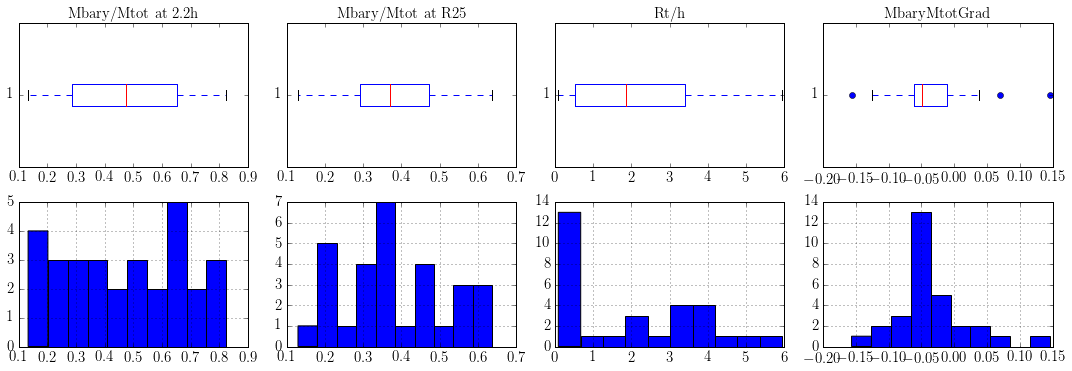

In [23]:
plt.figure(figsize=(15, 10))
plt.subplot(441)
plt.title('Mbary/Mtot at 2.2h')
plt.boxplot(rcd['MbaryMtot2h'], 0, 'ro', 0)
plt.subplot(442)
plt.title('Mbary/Mtot at R25')
plt.boxplot(rcd['MbaryMtotR25'], 0, 'ro', 0)
plt.subplot(443)
plt.title('Rt/h')
plt.boxplot(rcd['Rth'], 0, 'ro', 0)
plt.subplot(444)
plt.title('MbaryMtotGrad')
plt.boxplot(rcd['MbaryMtotGrad'], 0, 'ro', 0)
plt.subplot(445)
rcd['MbaryMtot2h'].hist()
plt.subplot(446)
rcd['MbaryMtotR25'].hist()
plt.subplot(447)
rcd['Rth'].hist()
plt.subplot(448)
rcd['MbaryMtotGrad'].hist()
plt.tight_layout()

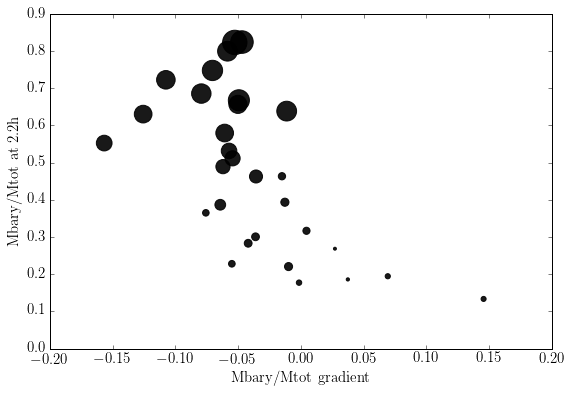

In [24]:
plt.figure(figsize=(9, 6))
plt.scatter(rcd['MbaryMtotGrad'], rcd['MbaryMtot2h'], c='k',s=rcd['Rth']*100., alpha=0.9)
plt.xlabel('Mbary/Mtot gradient')
plt.ylabel('Mbary/Mtot at 2.2h')
#plt.savefig("MbaryMtot_2hvsgrad.pdf")

#### Let's take a look at how these metrics correlate to each other.

In [25]:
rcd.corr()['MbaryMtot2h']

dML             -0.009642
bML              0.232222
Rc               0.641295
Vh               0.612196
Rtkpc            0.746160
Rth              0.947647
MbaryMtot2h      1.000000
MbaryMtotR25     0.921733
MbaryMtotGrad   -0.621081
Name: MbaryMtot2h, dtype: float64

Not surpisingly, the baryon mass fraction at 2.2 scale lengths correlates most strongly with the baryon mass fraction at $R_{25}$ and the transition radius. It is also correlated with the dark matter halo shape parameters, Rc and Vh. There is a slight anti-correlation with the baryon mass fraction gradient, which is somewhat apparent in the plot above. The lack of a strong correlation between these parameters is simply indicating that the baryon mass fraction slope does not depend on the normalization.

### Relation between mass distribution metrics grouped by morphological type
The plot above suggests that galaxies with similar mass distribution metrics tend to cluster. Before I try anything fancy, I want to first make sure that I won't just be grouping galaxies by morphological type. I'm going to assign galaxies to 4 groups based on their T-type:
- 'S0' for spheroidals (-1, -2)
- 'Sb' for early-type spirals (3, 4)
- 'Sc' for late-type spirals (5)
- 'Irr' for irregulars (10)

In [26]:
# Not all galaxies in df are in rcd, so need to re-index df
df_short = df.reindex(rcd.index)

In [27]:
# Create new column 'class' with galaxies grouped based on T-type:
class_dict = {-1:'S0',-2: 'S0',
              3: 'Sb', 4: 'Sb',
              5: 'Sc',10: 'Irr',
              8: 'Irr'}
df_short['class'] = df_short['T-type'].map(class_dict)

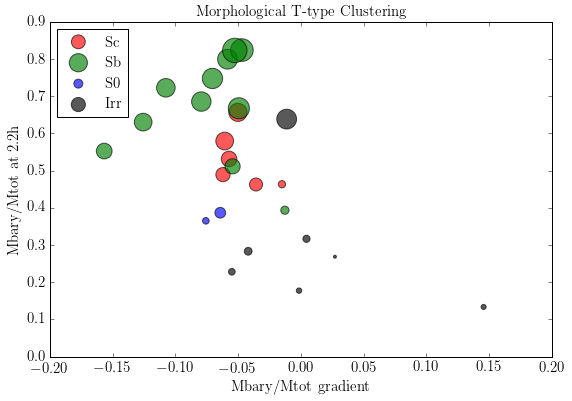

In [28]:
labels = ['Sc','Sb','S0','Irr']
colors = ['r','g','b','k']

plt.figure(figsize=(9, 6))
plt.title('Morphological T-type Clustering')
for i,group in enumerate(labels):
    gal_in_group = np.where(df_short['class'] == group)
    plt.scatter(rcd['MbaryMtotGrad'].ix[gal_in_group],rcd['MbaryMtot2h'].ix[gal_in_group],
                s=rcd['Rth'].ix[gal_in_group]*100.,c=colors[i],alpha=0.65,label=group)
plt.xlabel('Mbary/Mtot gradient')
plt.ylabel('Mbary/Mtot at 2.2h')
plt.legend(scatterpoints = 1, loc='upper left')
#plt.savefig("DMmetricsTmorph.pdf")

So, in fact, it looks like the galaxies are basically clustered based on their morphological type. I'm going to try a k-means clustering, anyways, but only using 3 groups. I'm curious to see if I just end up with a grouping that is equivalent to spirals, S0's, and irregulars.

### K-Means clustering on the Mass Distribution Metrics

In [29]:
metrics = ['MbaryMtot2h','MbaryMtotGrad','Rth']
clustDM = rcd[metrics]

In [30]:
from sklearn.cluster import KMeans

In [31]:
# Initialize the model with 2 parameters -- number of clusters and random state.
kmeans_model = KMeans(n_clusters=3, random_state=1)
# Fit the model
kmeans_model.fit(clustDM)
# Get the cluster assignments
DMkmeans_labels = kmeans_model.labels_

In [32]:
rcd['DMkmeans'] = DMkmeans_labels + 1 # The 0 just annoys me

In [33]:
df_short['DMkmeans'] = DMkmeans_labels + 1

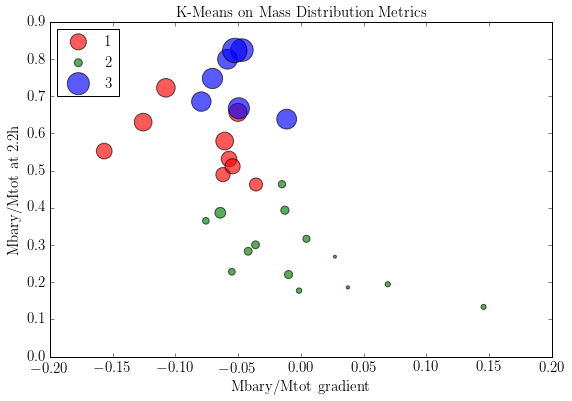

In [34]:
labels = np.arange(1,4)
colors = ['r','g','b']

plt.figure(figsize=(9, 6))
plt.title('K-Means on Mass Distribution Metrics')
for i,group in enumerate(labels):
    gal_in_group = np.where(rcd['DMkmeans'] == group)
    plt.scatter(rcd['MbaryMtotGrad'].ix[gal_in_group],rcd['MbaryMtot2h'].ix[gal_in_group],
                s=rcd['Rth'].ix[gal_in_group]*100.,c=colors[i],alpha=0.65,label=group)
plt.xlabel('Mbary/Mtot gradient')
plt.ylabel('Mbary/Mtot at 2.2h')
plt.legend(scatterpoints = 1, loc='upper left')
#plt.savefig("DMmetricsKmeans.pdf")

The distinction and clustering between galaxies using the k-means is similar to the morphological type classifications, but the S0's and irregulars have been grouped together. I'm going to use this grouping going forward.

## Do galaxies with similar mass distribution metrics have similar baryon properties?

One approach is to cluster together all the galaxies which have similar baryon properties and see if their group assignments match the group assignments from clustering on the mass distribution metrics. It's too cumbersome for k-means to try and group things based on a ton of different variables. Plus, many of the derived baryon properties are redundant (i.e. Mbary = Mstar + Mgas). I will try using PCA to identify the baryon properties which most distinguish different types of galaxies from one another.

## Principal Components Analysis

In [35]:
df.columns

Index([u'Done?', u'DMpc', u'D_ID', u'T-type', u'A_B', u'A_R', u'F_HI', u'W20',
       u'F_CO', u'F_CO_err', u'm_B', u'm_B_err', u'm_B,tot', u'm_R',
       u'm_R_err', u'm_R,tot', u'm_3.6', u'm_3.6_err', u'm_3.6,tot',
       u'log(F_Ha)', u'log(F_Ha)_err', u'EW', u'EW_err', u'h_R', u'D_25',
       u'D_HI', u'C_28', u'log(EW)_grad', u'(B-R)_grad', u'incl', u'Vflat',
       u'Vflaterr', u'DLTF', u'Duse', u'mB0', u'M_B', u'BR025', u'SFR', u'MHI',
       u'MH2', u'Mgas', u'Mstar', u'SSFR', u'Mbary', u'hkpc', u'd25kpc',
       u'dhikpc', u'BRgradkpc', u'logEWgradkpc'],
      dtype='object')

In [36]:
# Start with all the derived gas & star properties
pcaCols = ['Mstar','Mgas','Mbary','BR025','EW','SFR','SSFR','hkpc','d25kpc','dhikpc','C_28','BRgradkpc','logEWgradkpc']
pcadf = pd.DataFrame(unumpy.nominal_values(df_short[pcaCols]), columns=pcaCols, index=df_short.index)

In [37]:
# Put everything into log-space (B-R, EW, C28, BRgrad & EWgrad are already there)
logCols = ['Mstar','Mgas','Mbary','SFR','SSFR','hkpc','d25kpc','dhikpc']
pcadf[logCols] = pcadf[logCols].apply(lambda x: np.log10(x))

In [38]:
# Data needs to be in an array
pca_array = pcadf.values

The scales and units of the data are all over the place, so we'll standardize by setting the mean = 0 and variance = 1.

In [39]:
from sklearn.preprocessing import StandardScaler
pca_std = StandardScaler().fit_transform(pca_array)

Apply the PCA implementation from sklearn, which uses singular value decomposition to compute the principal components. First, we'll create the PCA model with as many components as there are variables to get an idea of how the variance is distributed across all attributes.

In [40]:
from sklearn.decomposition import PCA as PCA
pca_model = PCA(n_components=13)
pca_fit = pca_model.fit_transform(pca_std)

In [41]:
pca_var = pca_model.explained_variance_ratio_
pca_var

array([  5.51065476e-01,   1.74296393e-01,   1.19828736e-01,
         5.53546958e-02,   4.37259951e-02,   3.53515317e-02,
         8.55785967e-03,   4.95591810e-03,   3.93991112e-03,
         1.81764108e-03,   9.88253085e-04,   1.17588928e-04,
         3.80115282e-33])

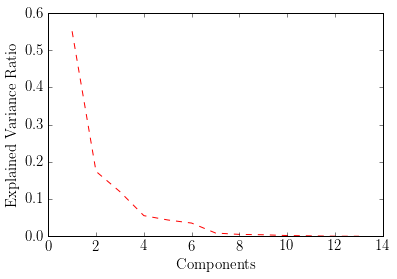

In [42]:
x = np.arange(1,14)
plt.figure(figsize=(6, 4))
plt.plot(x, pca_var, 'r--')
plt.xlabel('Components')
plt.ylabel('Explained Variance Ratio')
#plt.savefig("BaryonPCAscree.pdf")

In [43]:
pca_var.cumsum()

array([ 0.55106548,  0.72536187,  0.84519061,  0.9005453 ,  0.9442713 ,
        0.97962283,  0.98818069,  0.99313661,  0.99707652,  0.99889416,
        0.99988241,  1.        ,  1.        ])

Approx. 73% of the variance is explained by the first 2 components. By the 6th component, 98% of the variance has been accounted for, and there is very little information to gain by including more variables. Now we just have to figure out which 6 variables we need.

In [44]:
pca_loadings = pca_model.components_

In [45]:
pcaloaddf = pd.DataFrame(pca_loadings.T, index=pcadf.columns)
# Print the first 6 components
pcaloaddf.ix[:,:5]

,0,1,2,3,4,5
Mstar,-0.360910,0.053121,0.047596,-0.099133,-0.197878,0.215678
Mgas,-0.330536,0.228980,-0.140870,0.071110,0.181645,-0.156157
Mbary,-0.366162,0.071083,0.032276,-0.060984,-0.112842,0.121923
BR025,-0.281831,-0.307553,0.197264,-0.137996,-0.379931,0.251007
EW,0.146324,0.575177,0.048938,0.200836,-0.189751,0.070933
SFR,-0.327831,0.259338,0.034003,-0.059883,-0.200468,0.308644
SSFR,0.162574,0.571248,-0.047467,0.129707,0.030697,0.220708
hkpc,-0.338908,-0.008845,-0.186682,-0.008182,0.211133,-0.375079
d25kpc,-0.357012,0.108244,-0.138286,-0.031919,-0.014151,0.045140
dhikpc,-0.332449,0.133296,-0.175720,0.045398,0.300645,-0.257811


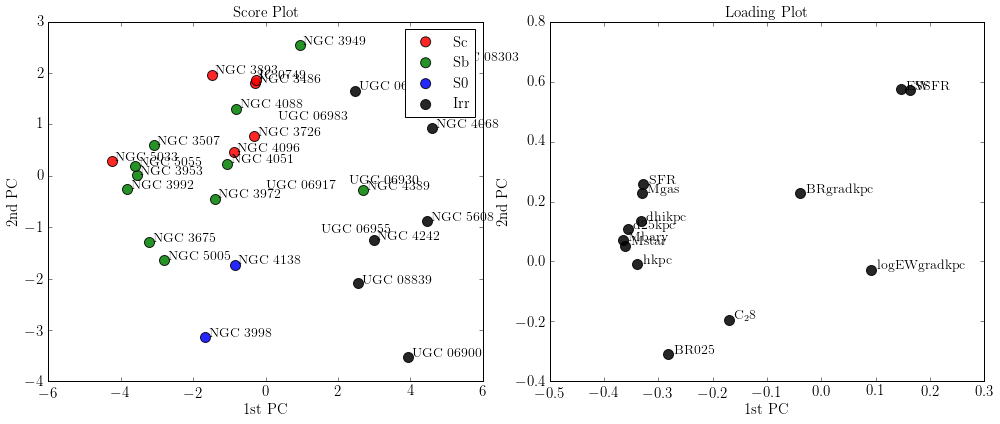

In [46]:
# Plot the scores and loadings on the first 2 principal components

variable_labels = pcaCols
galaxy_labels = df_short.index

labels = ['Sc','Sb','S0','Irr']
colors = ['r','g','b','k']

plt.figure(figsize=(14,6))

plt.subplot(121)
plt.title('Score Plot')
for i,group in enumerate(labels):
    gal_in_group = np.where(df_short['class'] == group)
    plt.scatter(pca_fit[gal_in_group,0], pca_fit[gal_in_group,1], 
                c=colors[i],s=100, alpha=0.85, label=group)
plt.xlabel('1st PC')
plt.ylabel('2nd PC')
plt.legend(scatterpoints = 1, loc='best')
xy = zip((pca_fit[:,0]+0.1), pca_fit[:,1])
for i in range(len(xy)):
    plt.annotate('%s' % galaxy_labels[i], xy=xy[i], textcoords='data', fontsize=14)

plt.subplot(122)
plt.title('Loading Plot')
plt.scatter(pcaloaddf[0], pcaloaddf[1], c='k',s=100, alpha=0.85, label=group)
plt.xlabel('1st PC')
plt.ylabel('2nd PC')
xy = zip((pcaloaddf[0]+0.01), pcaloaddf[1])
for i in range(len(xy)):
    plt.annotate('%s' % variable_labels[i], xy=xy[i], textcoords='data', fontsize=14)

plt.tight_layout()
#plt.savefig("PCAloadings_labels.pdf")

The score plot on the left demonstrates how the galaxies score on the first two components. There is a lot of variation in the scores, but the galaxies appear to fall in distinct groups based on their morphological types. For example, irregular galaxies appear to score high (in an absolute sense) on the first PC, but span a wide range in the second PC. Sc type galaxies, on the other hand, appear to score relatively high on the second component, but not on the first.

On the loading plot, variables that cluster together have similar behavior. For example, Mstar, Mbary, Mgas, SFR, h, DHI, and D25 all contribute to the variance on the first PC in a similar way, and do not contribute much variance to the second PC. EW and SSFR both have larger loadings on the second PC and "work" in the opposite direction of the B-R color and its gradient.

Taken together, these plots suggest there are differences between which gas and star properties best distinguish spiral, S0 and irregular galaxies. Sb and Sc type galaxies may be best described by mass and size, whereas irregular galaxies have more distinct modes of star formation activity. Early-type S0 galaxies can be best identified in terms of their B-R color.

Even though I just showed that galaxies separate well into groups based on morphological type, I'm going experiment with clustering on different combinations of gas and star variables to see if the group assignments match the mass distribution ones.

In [47]:
# Find the largest loadings for each PC
maxloaddf = pcaloaddf.apply(lambda x: np.absolute(x))
for i in range(6):
    print maxloaddf[i].argmax(), maxloaddf[i].max()

Mbary 0.36616218287
EW 0.575176867698
logEWgradkpc 0.632572958916
C_28 0.926528968567
logEWgradkpc 0.67902256893
BRgradkpc 0.625518855801


It may also be informative to look at the variables which have the largest cummulative loadings, rather than the largest loading in a single component. The loadings for each variable will be summed across the components, which will be weighted by their variance explained ratio.

In [48]:
# Print the absolute value of the components
#top6 = maxcompdf.ix[:,:5]
maxloaddf

,0,1,2,3,4,...,8,9,10,11,12
Mstar,0.360910,0.053121,0.047596,0.099133,0.197878,...,0.090084,0.207312,0.041028,0.377300,7.094534e-01
Mgas,0.330536,0.228980,0.140870,0.071110,0.181645,...,0.479580,0.551826,0.204741,0.125033,1.665335e-16
Mbary,0.366162,0.071083,0.032276,0.060984,0.112842,...,0.085064,0.147112,0.086331,0.824205,6.661338e-16
BR025,0.281831,0.307553,0.197264,0.137996,0.379931,...,0.060108,0.248514,0.300937,0.019710,1.110223e-16
EW,0.146324,0.575177,0.048938,0.200836,0.189751,...,0.506651,0.198217,0.138838,0.027402,2.220446e-16
SFR,0.327831,0.259338,0.034003,0.059883,0.200468,...,0.002986,0.245267,0.083536,0.346345,6.642153e-01
SSFR,0.162574,0.571248,0.047467,0.129707,0.030697,...,0.279720,0.067206,0.359099,0.159736,2.355714e-01
hkpc,0.338908,0.008845,0.186682,0.008182,0.211133,...,0.597984,0.145173,0.416615,0.063394,6.245005e-16
d25kpc,0.357012,0.108244,0.138286,0.031919,0.014151,...,0.018298,0.329151,0.716811,0.105954,9.436896e-16
dhikpc,0.332449,0.133296,0.175720,0.045398,0.300645,...,0.163940,0.569991,0.112031,0.023515,2.636780e-16


In [49]:
def score(df, index):
    score = 0
    for pc in df.columns:
        score += df.ix[index,pc] * pca_var[pc]
    return score

In [50]:
scores = []
for index in maxloaddf.index:
    scores.append(score(maxloaddf, index))

In [51]:
var_scores = zip(maxloaddf.index, scores)

In [52]:
sort_var_scores = sorted(var_scores, key = lambda x: x[1])
sort_var_scores

[('logEWgradkpc', 0.17772615487379817),
 ('BRgradkpc', 0.18325929173153452),
 ('C_28', 0.21259293530959308),
 ('EW', 0.21582957993090932),
 ('SSFR', 0.21801181238479778),
 ('Mbary', 0.23383525784826834),
 ('Mstar', 0.23788045943381331),
 ('hkpc', 0.23984064020731535),
 ('d25kpc', 0.24200387777105931),
 ('SFR', 0.2557812794636356),
 ('dhikpc', 0.25937719431996525),
 ('Mgas', 0.26332410263032818),
 ('BR025', 0.27156879372589082)]

### K-Means Clustering on Largest Variance Baryon Properties

In [53]:
# Take top 6
overallClustCols = ['dhikpc','SFR','Mgas','hkpc','BR025','d25kpc']
overallVardf = pcadf[overallClustCols]

In [54]:
# Initialize the model with 2 parameters -- number of clusters and random state.
kmeans_model = KMeans(n_clusters=3, random_state=1)
# Fit the model
kmeans_model.fit(overallVardf)
# Get the cluster assignments
Barykmeans_labels = kmeans_model.labels_

In [55]:
df_short['Barykmeans'] = Barykmeans_labels + 1

In [56]:
rcd['Barykmeans'] = Barykmeans_labels + 1

Look at the score plot to see how this grouping translates across the first 2 components.

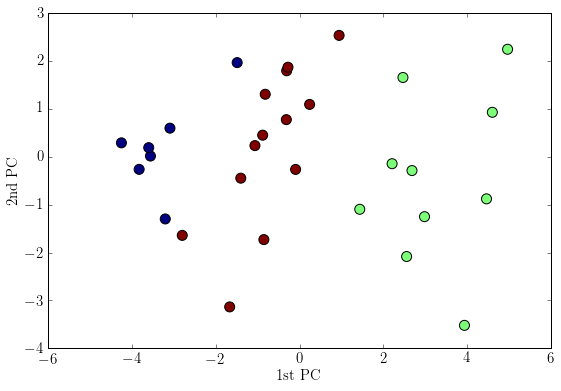

In [57]:
plt.figure(figsize=(9, 6))
plt.scatter(x=pca_fit[:,0], y=pca_fit[:,1], c=df_short['Barykmeans'],s=100)
plt.xlabel('1st PC')
plt.ylabel('2nd PC')
#plt.savefig("PCABarykmeans.pdf")

We can see that the galaxy groups separate along the first principal component. This makes sense given that most of the variables were ones which loaded highly on the first PC. Now, let's see how similar these group assignments are to the mass distribution metric group assignments.

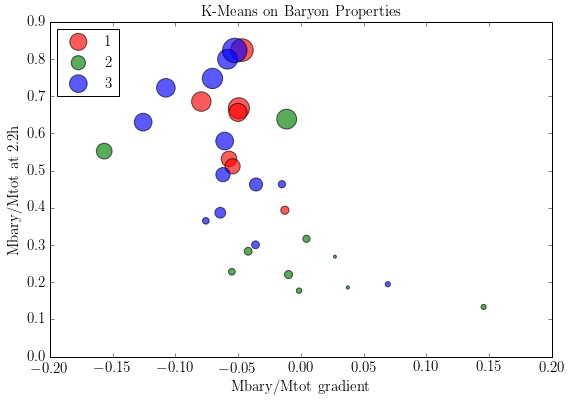

In [58]:
labels = np.arange(1,4)
colors = ['r','g','b']

plt.figure(figsize=(9, 6))
plt.title('K-Means on Baryon Properties')
for i,group in enumerate(labels):
    gal_in_group = np.where(rcd['Barykmeans'] == group)
    plt.scatter(rcd['MbaryMtotGrad'].ix[gal_in_group],rcd['MbaryMtot2h'].ix[gal_in_group],
                s=rcd['Rth'].ix[gal_in_group]*100.,c=colors[i],alpha=0.65,label=group)
plt.xlabel('Mbary/Mtot gradient')
plt.ylabel('Mbary/Mtot at 2.2h')
plt.legend(scatterpoints = 1, loc='upper left')
#plt.savefig("DMmetricsBaryKmeans.pdf")

There is obviously not a one-to-one correlation between the distinguishing baryon characteristics and the distinguishing mass distribution characteristics. But, this doesn't necessarily answer the question which, if any, of the baryon properties are similar within each mass distribution group.

### k-means clustering on baryon properties with top PC loadings

In [59]:
# Take top 6
topClustCols = ['Mbary','EW','logEWgradkpc','C_28','BRgradkpc']
topPCdf = pcadf[topClustCols]

In [60]:
# Initialize the model with 2 parameters -- number of clusters and random state.
kmeans_model = KMeans(n_clusters=3, random_state=1)
# Fit the model
kmeans_model.fit(topPCdf)
# Get the cluster assignments
topPCkmeans_labels = kmeans_model.labels_

In [61]:
df_short['topPCkmeans'] = topPCkmeans_labels + 1

In [62]:
rcd['topPCkmeans'] = topPCkmeans_labels + 1

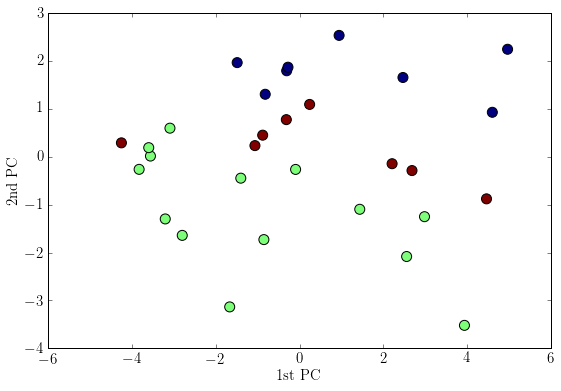

In [63]:
plt.figure(figsize=(9, 6))
plt.scatter(x=pca_fit[:,0], y=pca_fit[:,1], c=df_short['topPCkmeans'],s=100)
plt.xlabel('1st PC')
plt.ylabel('2nd PC')
#plt.savefig("PCABarykmeans.pdf")

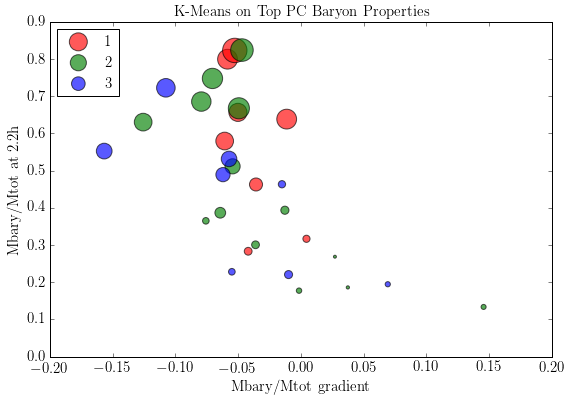

In [64]:
labels = np.arange(1,4)
colors = ['r','g','b']

plt.figure(figsize=(9, 6))
plt.title('K-Means on Top PC Baryon Properties')
for i,group in enumerate(labels):
    gal_in_group = np.where(rcd['topPCkmeans'] == group)
    plt.scatter(rcd['MbaryMtotGrad'].ix[gal_in_group],rcd['MbaryMtot2h'].ix[gal_in_group],
                s=rcd['Rth'].ix[gal_in_group]*100.,c=colors[i],alpha=0.65,label=group)
plt.xlabel('Mbary/Mtot gradient')
plt.ylabel('Mbary/Mtot at 2.2h')
plt.legend(scatterpoints = 1, loc='upper left')
#plt.savefig("DMmetricsBaryKmeans.pdf")

The galaxies grouped this way do not distinguish themselves in the dark matter properties frame of reference.

## Max. Disk Version
Coming soon!

In [66]:
## Start by reading all the files into a list ##

with open("maxDiskFiles.txt", 'r') as f:
    maxDiskFiles = f.read().splitlines()

In [67]:
## Create a data frame to store all the results from the rotfit files ##
# Call functions rotfitParams, rtrans, massFracDist, twoPointTwoh, & baryatR25 from rcd_results.py

maxdf = []
for file in maxDiskFiles:
    gal,dml,bml,rc,vh = rotfitParams(file)
    #rt = rtrans(file)
    hkpcGal = df['hkpc'][gal]
    r25kpcGal = (df['d25kpc'][gal])/2.
    #rth = rt/hkpcGal
    gal, r, Mrat = massFracDist(file)
    logMrat = np.log10(Mrat)
    rh = r/hkpcGal
    x = np.array([])
    y = np.array([])
    for i in range(len(rh)):
        if rh[i] >= 1.0:
            x = np.append(x, rh[i])
            y = np.append(y, logMrat[i])
    # Fit linear regression model
    slope, intercept, r_value, p_value, slope_std_error = stats.linregress(x, y)
    MbaryMtot2h = twoPointTwoh(file, hkpcGal)[1]
    MbaryMtotR25 = baryatR25(file, r25kpcGal)[1]
    maxdf.append([gal,dml,bml,rc,vh,MbaryMtot2h,MbaryMtotR25,slope])
cols = ['gal','dML','bML','Rc','Vh','MbaryMtot2h','MbaryMtotR25','MbaryMtotGrad']
maxdf = pd.DataFrame(maxdf, columns=cols)
maxdf = maxdf.set_index('gal')

In [68]:
# Get rid of un-physical result
maxrcd = maxdf.drop(['NGC 3941'])

In [69]:
maxrcd.head()

,dML,bML,Rc,Vh,MbaryMtot2h,MbaryMtotR25,MbaryMtotGrad
gal,,,,,,,
NGC 3486,0.981204,0.0,7.899092,158.387589,0.823848,0.538047,-0.052082
NGC 3507,0.791202,0.0,24.703100,245.445602,1.050676,0.874176,-0.054815
UGC 06161,1.056543,0.0,3.374415,91.329658,0.437131,0.421700,-0.076769
NGC 3675,0.657270,0.0,16.825855,268.188599,0.877801,0.743174,-0.079962
NGC 3726,1.068662,0.0,12.663983,180.529236,0.946923,0.863406,-0.029314


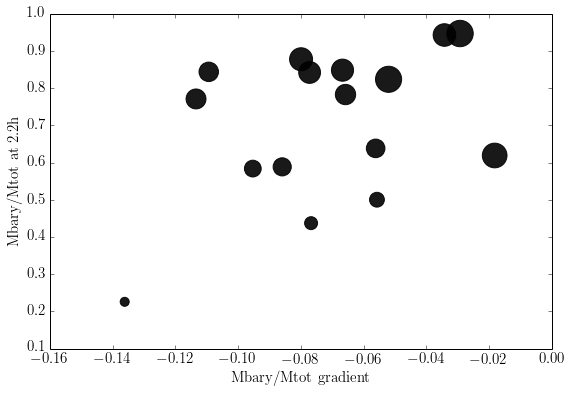

In [75]:
plt.figure(figsize=(9, 6))
plt.scatter(maxrcd['MbaryMtotGrad'], maxrcd['MbaryMtot2h'], c='k',s=maxrcd['Rth']*100., alpha=0.9)
plt.xlabel('Mbary/Mtot gradient')
plt.ylabel('Mbary/Mtot at 2.2h')
#plt.savefig("MbaryMtot_2hvsgrad_maxDisk.pdf")

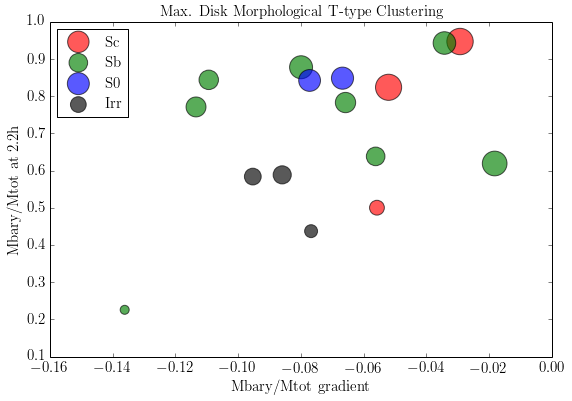

In [77]:
labels = ['Sc','Sb','S0','Irr']
colors = ['r','g','b','k']

plt.figure(figsize=(9, 6))
plt.title('Max. Disk Morphological T-type Clustering')
for i,group in enumerate(labels):
    gal_in_group = np.where(df_short['class'] == group)
    plt.scatter(maxrcd['MbaryMtotGrad'].ix[gal_in_group],maxrcd['MbaryMtot2h'].ix[gal_in_group],
                s=maxrcd['Rth'].ix[gal_in_group]*100.,c=colors[i],alpha=0.65,label=group)
plt.xlabel('Mbary/Mtot gradient')
plt.ylabel('Mbary/Mtot at 2.2h')
plt.legend(scatterpoints = 1, loc='upper left')
#plt.savefig("DMmetricsTmorph_maxDisk.pdf")

In [78]:
clustDMmaxDisk = maxrcd[metrics]

In [79]:
# Initialize the model with 2 parameters -- number of clusters and random state.
kmeans_model = KMeans(n_clusters=3, random_state=1)
# Fit the model
kmeans_model.fit(clustDMmaxDisk)
# Get the cluster assignments
DMmaxkmeans_labels = kmeans_model.labels_

In [80]:
maxrcd['DMkmeans'] = DMmaxkmeans_labels + 1 # The 0 just annoys me

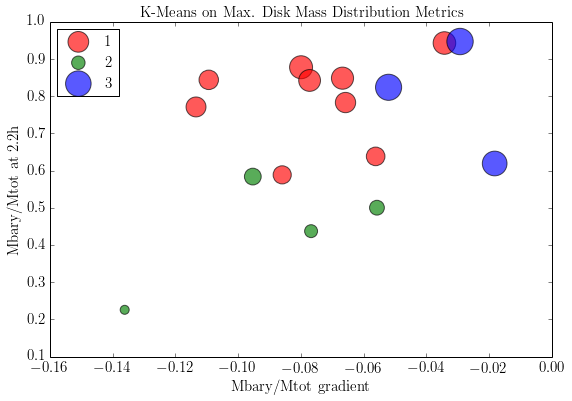

In [83]:
labels = np.arange(1,4)
colors = ['r','g','b']

plt.figure(figsize=(9, 6))
plt.title('K-Means on Max. Disk Mass Distribution Metrics')
for i,group in enumerate(labels):
    gal_in_group = np.where(maxrcd['DMkmeans'] == group)
    plt.scatter(maxrcd['MbaryMtotGrad'].ix[gal_in_group],maxrcd['MbaryMtot2h'].ix[gal_in_group],
                s=maxrcd['Rth'].ix[gal_in_group]*100.,c=colors[i],alpha=0.65,label=group)
plt.xlabel('Mbary/Mtot gradient')
plt.ylabel('Mbary/Mtot at 2.2h')
plt.legend(scatterpoints = 1, loc='upper left')
#plt.savefig("DMmetricsKmeans_maxDisk.pdf")

### Quick comparison plots between mass distribution metrics and stellar properties

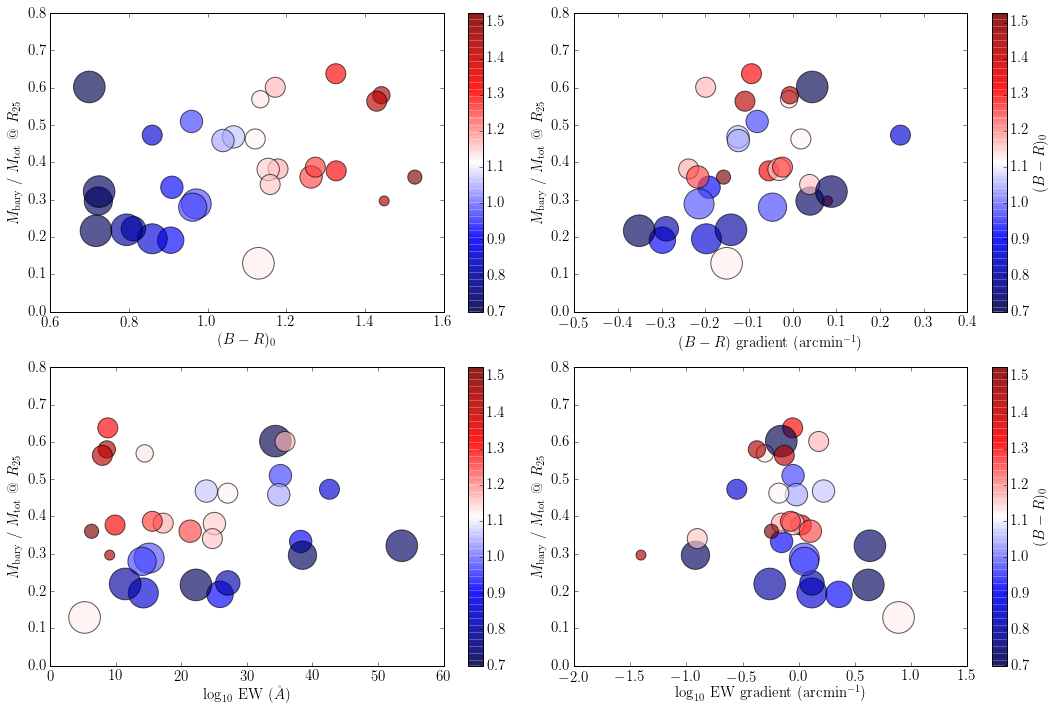

In [70]:
plt.figure(figsize=(15,10))

plt.subplot(221)
Mrat25vsBR = plt.scatter(unumpy.nominal_values(df_short['BR025']),rcd['MbaryMtotR25'],
                        c=unumpy.nominal_values(df_short['BR025']),s=np.absolute(df_short['T-type'])*100,cmap=galColor,alpha=0.65)
plt.xlabel('($B-R$)$_0$')
plt.ylabel('$M_\mathrm{bary}$ / $M_\mathrm{tot}$ $@$ $R_{25}$')
cbar = plt.colorbar()
#cbar.set_label('($B-R$)$_0$')

ax = plt.subplot(222)
Mrat25vsBRgrad = plt.scatter(df_short['(B-R)_grad'],rcd['MbaryMtotR25'],
                         c=unumpy.nominal_values(df_short['BR025']),s=np.absolute(df_short['T-type'])*100,cmap=galColor,alpha=0.65)
plt.xlabel('($B-R$) gradient (arcmin$^{-1}$)')
plt.ylabel('$M_\mathrm{bary}$ / $M_\mathrm{tot}$ $@$ $R_{25}$')
#ax.set_yticklabels([])
cbar = plt.colorbar()
cbar.set_label('($B-R$)$_0$')

plt.subplot(223)
Mrat25vsEW = plt.scatter(unumpy.nominal_values(df_short['EW']),rcd['MbaryMtotR25'],
                        c=unumpy.nominal_values(df_short['BR025']),s=np.absolute(df_short['T-type'])*100,cmap=galColor,alpha=0.65)
plt.xlabel('$\log_{10}$ EW ($\AA$)')
plt.ylabel('$M_\mathrm{bary}$ / $M_\mathrm{tot}$ $@$ $R_{25}$')
cbar = plt.colorbar()
#cbar.set_label('($B-R$)$_0$')

ax = plt.subplot(224)
Mrat25vsEWgrad = plt.scatter(df_short['log(EW)_grad'],rcd['MbaryMtotR25'],
                         c=unumpy.nominal_values(df_short['BR025']),s=np.absolute(df_short['T-type'])*100,cmap=galColor,alpha=0.65)
plt.xlabel('$\log_{10}$ EW gradient (arcmin$^{-1}$)')
plt.ylabel('$M_\mathrm{bary}$ / $M_\mathrm{tot}$ $@$ $R_{25}$')
#ax.set_yticklabels([])
cbar = plt.colorbar()
cbar.set_label('($B-R$)$_0$')

plt.tight_layout()
#plt.savefig("fixMLmassFracStarProps.pdf")

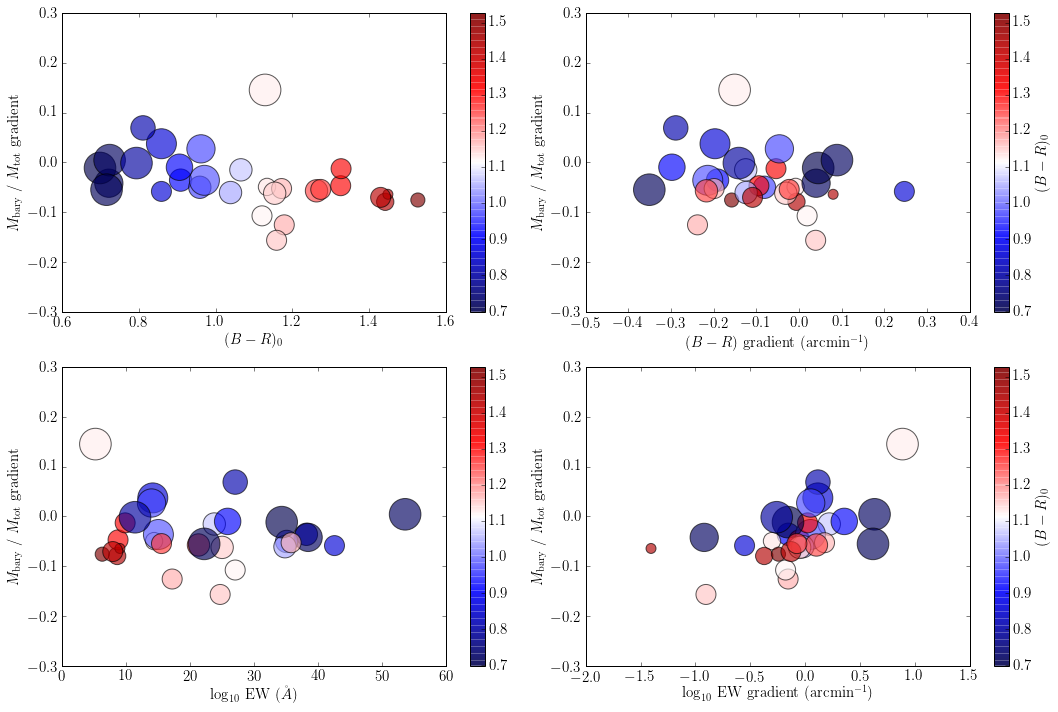

In [71]:
plt.figure(figsize=(15,10))

plt.subplot(221)
Mrat25vsBR = plt.scatter(unumpy.nominal_values(df_short['BR025']),rcd['MbaryMtotGrad'],
                        c=unumpy.nominal_values(df_short['BR025']),s=np.absolute(df_short['T-type'])*100,cmap=galColor,alpha=0.65)
plt.xlabel('($B-R$)$_0$')
plt.ylabel('$M_\mathrm{bary}$ / $M_\mathrm{tot}$ gradient')
cbar = plt.colorbar()
#cbar.set_label('($B-R$)$_0$')

ax = plt.subplot(222)
Mrat25vsBRgrad = plt.scatter(df_short['(B-R)_grad'],rcd['MbaryMtotGrad'],
                         c=unumpy.nominal_values(df_short['BR025']),s=np.absolute(df_short['T-type'])*100,cmap=galColor,alpha=0.65)
plt.xlabel('($B-R$) gradient (arcmin$^{-1}$)')
plt.ylabel('$M_\mathrm{bary}$ / $M_\mathrm{tot}$ gradient')
#ax.set_yticklabels([])
cbar = plt.colorbar()
cbar.set_label('($B-R$)$_0$')

plt.subplot(223)
Mrat25vsEW = plt.scatter(unumpy.nominal_values(df_short['EW']),rcd['MbaryMtotGrad'],
                        c=unumpy.nominal_values(df_short['BR025']),s=np.absolute(df_short['T-type'])*100,cmap=galColor,alpha=0.65)
plt.xlabel('$\log_{10}$ EW ($\AA$)')
plt.ylabel('$M_\mathrm{bary}$ / $M_\mathrm{tot}$ gradient')
cbar = plt.colorbar()
#cbar.set_label('($B-R$)$_0$')

ax = plt.subplot(224)
Mrat25vsEWgrad = plt.scatter(df_short['log(EW)_grad'],rcd['MbaryMtotGrad'],
                         c=unumpy.nominal_values(df_short['BR025']),s=np.absolute(df_short['T-type'])*100,cmap=galColor,alpha=0.65)
plt.xlabel('$\log_{10}$ EW gradient (arcmin$^{-1}$)')
plt.ylabel('$M_\mathrm{bary}$ / $M_\mathrm{tot}$ gradient')
#ax.set_yticklabels([])
cbar = plt.colorbar()
cbar.set_label('($B-R$)$_0$')

plt.tight_layout()
#plt.savefig("fixMLmassGradStarProps.pdf")

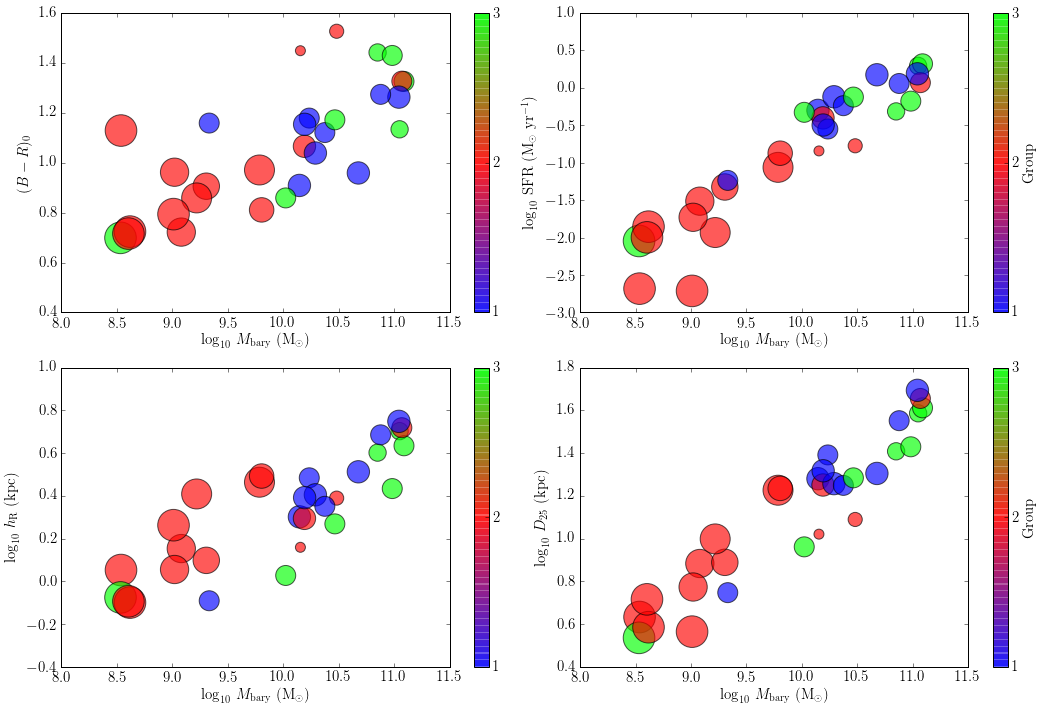

In [73]:
groupColor = plt.cm.get_cmap('brg')

plt.figure(figsize=(15,10))

plt.subplot(221)
BRvsMbary = plt.scatter(x=unumpy.nominal_values(unumpy.log10(df_short['Mbary'])),y=unumpy.nominal_values(df_short['BR025']),
                        c=rcd['DMkmeans'],s=np.absolute(df_short['T-type'])*100,cmap=groupColor,alpha=0.65)
plt.xlabel('$\log_{10}$ $M_\mathrm{bary}$ (M$_{\odot}$)')
plt.ylabel('($B-R$)$_0$')
cbar = plt.colorbar()
cbar.set_ticks([1,2,3])

plt.subplot(222)
SFRvsMbary = plt.scatter(unumpy.nominal_values(unumpy.log10(df_short['Mbary'])),unumpy.nominal_values(unumpy.log10(df_short['SFR'])),
                         c=rcd['DMkmeans'],s=np.absolute(df_short['T-type'])*100,cmap=groupColor,alpha=0.65)
plt.xlabel('$\log_{10}$ $M_\mathrm{bary}$ (M$_{\odot}$)')
plt.ylabel('$\log_{10}$ SFR (M$_{\odot}$ yr$^{-1}$)')
cbar = plt.colorbar()
cbar.set_label('Group')
cbar.set_ticks([1,2,3])

plt.subplot(223)
hvsMbary = plt.scatter(unumpy.nominal_values(unumpy.log10(df_short['Mbary'])),unumpy.nominal_values(unumpy.log10(df_short['hkpc'])),
                         c=rcd['DMkmeans'],s=np.absolute(df_short['T-type'])*100,cmap=groupColor,alpha=0.65)
plt.xlabel('$\log_{10}$ $M_\mathrm{bary}$ (M$_{\odot}$)')
plt.ylabel('$\log_{10}$ $h_\mathrm{R}$ (kpc)')
cbar = plt.colorbar()
cbar.set_ticks([1,2,3])

plt.subplot(224)
hvsMbary = plt.scatter(unumpy.nominal_values(unumpy.log10(df_short['Mbary'])),unumpy.nominal_values(unumpy.log10(df_short['d25kpc'])),
                         c=rcd['DMkmeans'],s=np.absolute(df_short['T-type'])*100,cmap=groupColor,alpha=0.65)
plt.xlabel('$\log_{10}$ $M_\mathrm{bary}$ (M$_{\odot}$)')
plt.ylabel('$\log_{10}$ $D_{25}$ (kpc)')
cbar = plt.colorbar()
cbar.set_label('Group')
cbar.set_ticks([1,2,3])

plt.tight_layout()
#plt.savefig("StellarPropsvsMbary_kmeans.pdf")